### This notebook generates the moisture-precip binnings for MCSs in the reanalysis-convective tracking data. First import libraries and constants.

In [1]:
import numpy as np
import scipy as sp
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import numpy.ma as ma
import seaborn as sns
import scipy.optimize
from matplotlib import cm
from numpy import unravel_index

plt.rcParams.update({'font.size': 12})

warnings.filterwarnings(action='ignore')

from plotting_utilities import *
from thermodynamic_functions import *

In [2]:
g = 9.8 # gravitational acceleration [m s-2]
rho_air = 1.395 # density of air (kg m-3)
rho_water = 1000 #density of water (kg m-3)
eps = 0.01802/0.02897 # ratio of MW_water to MW_air

In [3]:
# array of years
years = np.arange( 1983, 2008 )

# create list of file names
file_years = file_concatenator(years)

# Are we only looking at tropical MCSs?
minlat_array = nc_open_compile(file_years,"min latitude")
print(np.nanmin(minlat_array))
maxlat_array = nc_open_compile(file_years,"max latitude")
print(np.nanmax(maxlat_array))
tropical_indx = np.argwhere( (minlat_array >= -30) & (maxlat_array <= 30) )[:,0]
print(tropical_indx.shape)

# applying same for MCS lifetime and morphology
lifetime_array = nc_open_compile(file_years,"lifetime")
lifetime_ERAI = negative_to_nan(lifetime_array)[tropical_indx]
maxrad_array = nc_open_compile(file_years,"maxrad")
maxrad_ERAI = negative_to_nan(maxrad_array)[tropical_indx]
minctt_array = nc_open_compile(file_years,"minctt")
minctt_ERAI = negative_to_nan(minctt_array)[tropical_indx]

-56.0
56.0
(695667,)


In [4]:
# array of years
years = np.arange( 1983, 2008 )

# create list of file names
file_years = file_concatenator(years)

# applying same for pmax and pacc
pmax_array = nc_open_compile(file_years,"pmax")
pmax_ERAI = negative_to_nan(pmax_array)[tropical_indx]
pacc_array = nc_open_compile(file_years,"pacc")
pacc_ERAI = negative_to_nan(pacc_array)[tropical_indx]*3600 # convert to m3 / h

# extract pressure from the data files
# water vapour levels opened and vstacked, negatives removed
qv_array = nc_open_compile( file_years, "qv", 'stack' )
qv_ERAI = negative_to_nan(qv_array)[tropical_indx]

#pressure level values converted into double point precision
#factor of 100 converts hPa to Pa. we want to use SI units exclusively below.
plev_ERAI = np.double((xr.open_dataset(file_years[0])).pressure.data)*100

# calculate the saturation vapor mixing ratio, Curry & Webster (4.37)
temp_ERAI = nc_open_compile( file_years, "temperature", 'stack' )[tropical_indx]
qvsat_ERAI = eps * satVapP_liq(temp_ERAI) / ( plev_ERAI - satVapP_liq(temp_ERAI) )

In [5]:
#integral computed using trapezoidal integration
integral_ERAI = np.trapz( x=plev_ERAI, y=qv_ERAI )

#integral computed using trapezoidal integration - assuming complete saturation in the column
integral_sat_ERAI = np.trapz( x=plev_ERAI, y=qvsat_ERAI )

#cwvc calculated, the factor of 1000 converts m to mm
cwvc_ERAI = integral_ERAI / (rho_water*g) * 1000
print( 'Min, Mean, and Max CWVC [mm]: ' + str(np.nanmin(cwvc_ERAI)) + ' ' + str(np.nanmean(cwvc_ERAI)) + ' ' + str(np.nanmax(cwvc_ERAI)) )

#csf calculated, multiply by 100 to convert to a %
csf_ERAI = integral_ERAI / integral_sat_ERAI * 100
print( 'Min, Mean, and Max CSF [%]: ' + str(np.nanmin(csf_ERAI)) + ' ' + str(np.nanmean(csf_ERAI)) + ' ' + str(np.nanmax(csf_ERAI)) )

Min, Mean, and Max CWVC [mm]: 0.5510099275241246 40.79797889288164 80.5948213973405
Min, Mean, and Max CSF [%]: 1.1126021228933392 70.21310787626841 523.160202634015


In [17]:
# create bins in cwvc and evaluate corresponding precipitation percentiles
cwvc_bins, pmax_vals, pmax_95_vals, pmax_99_vals, cwvc_error, pmax_error, cwvc_max, pmax_max = \
    bin_stat_function( 35, 5, 75, cwvc_ERAI, pmax_ERAI, threshold=100 )

# create bins in column saturation fraction and evaluate corresponding precipitation percentiles
csf_bins, pmax_vals2, pmax_95_vals2, pmax_99_vals2, csf_error, pmax_error2, csf_max, pmax_max2 = \
    bin_stat_function( 35, 0, 100, csf_ERAI, pmax_ERAI, threshold=100 )

# create bins in column saturation fraction and evaluate corresponding precip accumulation percentiles
csf_bins, pacc_vals2, pacc_95_vals2, pacc_99_vals2, csf_error, pacc_error2, csf_max, pacc_max2 = \
    bin_stat_function( 35, 0, 100, csf_ERAI, pacc_ERAI, threshold=100 )

In [89]:
# create bins in column saturation fraction and evaluate corresponding precipitation percentiles for longest-lived systems
csf_bins_old, pmax_vals2_old, _, pmax_99_vals2_old, _, _, _, _ = \
    bin_stat_function( 35, 0, 100, csf_ERAI[lifetime_ERAI > 12], pmax_ERAI[lifetime_ERAI > 12], threshold=100 )

# create bins in column saturation fraction and evaluate corresponding precipitation percentiles for shortest-lived systems
csf_bins_young, pmax_vals2_young, _, pmax_99_vals2_young, _, _, _, _ = \
    bin_stat_function( 35, 0, 100, csf_ERAI[lifetime_ERAI <= 3], pmax_ERAI[lifetime_ERAI <= 3], threshold=100 )

# create bins in column saturation fraction and evaluate corresponding precipitation percentiles for smallest systems
csf_bins_small, pmax_vals2_small, _, pmax_99_vals2_small, _, _, _, _ = \
    bin_stat_function( 35, 0, 100, csf_ERAI[maxrad_ERAI <= 150], pmax_ERAI[maxrad_ERAI <= 150], threshold=100 )

# create bins in column saturation fraction and evaluate corresponding precipitation percentiles for largest systems
csf_bins_large, pmax_vals2_large, _, pmax_99_vals2_large, _, _, _, _ = \
    bin_stat_function( 35, 0, 100, csf_ERAI[maxrad_ERAI > 400], pmax_ERAI[maxrad_ERAI > 400], threshold=100 )

# create bins in column saturation fraction and evaluate corresponding precipitation percentiles for deepest systems
csf_bins_deep, pmax_vals2_deep, _, pmax_99_vals2_deep, _, _, _, _ = \
    bin_stat_function( 35, 0, 100, csf_ERAI[minctt_ERAI <= 185], pmax_ERAI[minctt_ERAI <= 185], threshold=100 )

# create bins in column saturation fraction and evaluate corresponding precipitation percentiles for shallowest systems
csf_bins_shallow, pmax_vals2_shallow, _, pmax_99_vals2_shallow, _, _, _, _ = \
    bin_stat_function( 35, 0, 100, csf_ERAI[minctt_ERAI > 205], pmax_ERAI[minctt_ERAI > 205], threshold=100 )

## Figure 4 - Binning of CSF and precipitation across percentiles

In [90]:
# exponential fit between CSF and precipitation across percentiles
def monoexp(x, m, a):
    return m * np.exp(a * x)

# fit an exponential to the CSF-Precip relationship and assess goodness-of-fit
# CSF input to the curve_fit is a decimal not a percentage, hence /100.
p0 = [ 1, 11 ]
i = np.where( ~np.isnan(csf_bins) )
params, cv = scipy.optimize.curve_fit( monoexp, csf_bins[i]/100., pmax_vals2[i], p0 )
m, a = params
print( m, a )

i = np.where( ~np.isnan(csf_bins_young) )
params, cv = scipy.optimize.curve_fit( monoexp, csf_bins_young[i]/100., pmax_vals2_young[i], p0 )
m2, a2 = params
print( m2, a2 )

i = np.where( ~np.isnan(csf_bins_old) )
params, cv = scipy.optimize.curve_fit( monoexp, csf_bins_old[i]/100., pmax_vals2_old[i], p0 )
m3, a3 = params
print( m3, a3 )

i = np.where( ~np.isnan(csf_bins_small) )
params, cv = scipy.optimize.curve_fit( monoexp, csf_bins_small[i]/100., pmax_vals2_small[i], p0 )
m4, a4 = params
print( m4, a4 )

i = np.where( ~np.isnan(csf_bins_large) )
params, cv = scipy.optimize.curve_fit( monoexp, csf_bins_large[i]/100., pmax_vals2_large[i], p0 )
m5, a5 = params
print( m5, a5 )

i = np.where( ~np.isnan(csf_bins_deep) )
params, cv = scipy.optimize.curve_fit( monoexp, csf_bins_deep[i]/100., pmax_vals2_deep[i], p0 )
m6, a6 = params
print( m6, a6 )

i = np.where( ~np.isnan(csf_bins_shallow) )
params, cv = scipy.optimize.curve_fit( monoexp, csf_bins_shallow[i]/100., pmax_vals2_shallow[i], p0 )
m7, a7 = params
print( m7, a7 )

squaredDiffs = np.square(pmax_vals2[i] - monoexp(csf_bins[i]/100., m, a))
squaredDiffsFromMean = np.square(pmax_vals2[i] - np.mean(pmax_vals2[i]))
rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
print( rSquared )

0.4324682307722294 3.3097704904718594
0.3056292951227786 3.56811885859584
0.5898950685320884 3.1885622981024664
0.21411008511257218 3.86642705726667
0.627662017232398 3.1134328085761687
0.7131485575911494 2.9685469918585627
0.24753491219209273 3.839543053226344
0.9877436136737531


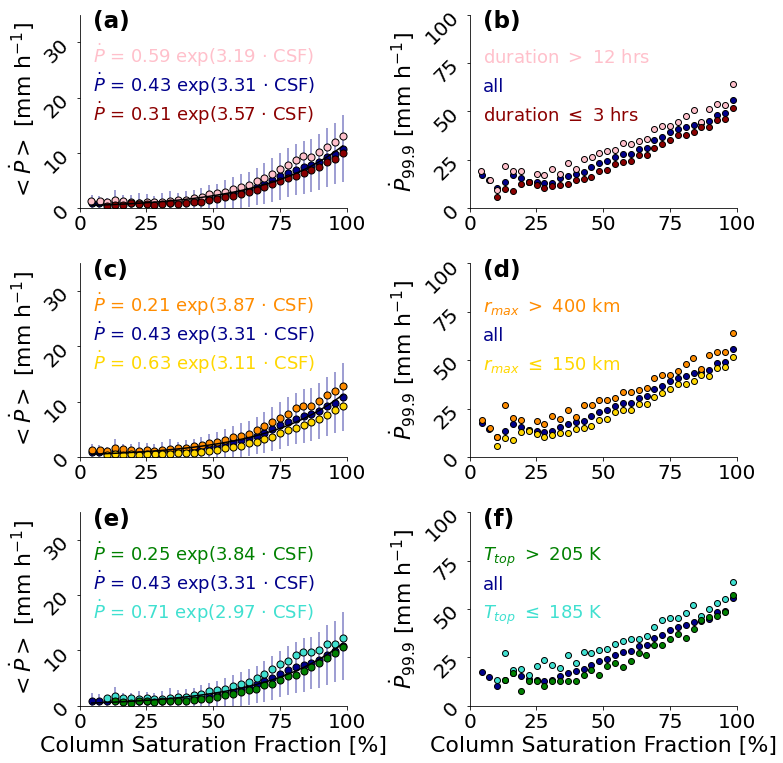

In [92]:
fig, ax = plt.subplots( 3, 2, figsize =(11, 11) )

ylab = [ r'$< \dot{P} >$ [mm h$^{-1}$]', r'$\dot{P}_{99.9}$ [mm h$^{-1}$]', r'$< \dot{P} >$ [mm h$^{-1}$]',
        r'$\dot{P}_{99.9}$ [mm h$^{-1}$]', r'$< \dot{P} >$ [mm h$^{-1}$]', r'$\dot{P}_{99.9}$ [mm h$^{-1}$]' ]
labels = [ '', '', '', '', 'Column Saturation Fraction [%]', 'Column Saturation Fraction [%]' ]
let = [ '(a)', '(b)', '(c)', '(d)', '(e)', '(f)' ]
font_size = 20
plt.rcParams.update({
    'font.size':font_size,
    'axes.labelsize':font_size+2,
    'xtick.labelsize':font_size,
    'ytick.labelsize':font_size,
    'legend.fontsize':font_size,
})

for i, axis in enumerate(ax.flat): 
    axis.set( ylabel = ylab[i] )
    axis.set_xlim( [0, 100] )
    axis.spines['top'].set_visible( False )
    axis.spines['right'].set_visible( False )
    axis.set( xlabel = labels[i] )
    for t in axis.get_yticklabels():
        t.set_rotation(45)
    axis.text( 0.05, 0.93, let[i], transform=axis.transAxes, fontsize=font_size+3, weight='bold' )
    
    if i == 0:
        y = monoexp( csf_bins/100, m, a )
        axis.plot( csf_bins, y, lw=1.5, color='k' )
        axis.scatter( csf_bins, pmax_vals2, color = 'darkblue', s=50, edgecolor='k' )
        axis.errorbar( csf_bins, pmax_vals2, xerr=csf_error/2, yerr=pmax_error2/2, color = 'darkblue', ls='none', zorder=0, 
                     alpha=0.5 )
        axis.scatter( csf_bins_old, pmax_vals2_old, s=50, color = 'pink', edgecolor='k' )
        axis.scatter( csf_bins_young, pmax_vals2_young, s=50, color = 'darkred', edgecolor='k' )
        axis.set_ylim([0, 35])
        axis.text( 0.05, 0.75, r'$\dot P$ = {:.2f} exp({:.2f} $\cdot$ CSF)'.format(m3,a3), transform=axis.transAxes, 
                  color='pink', fontsize=18 )
        axis.text( 0.05, 0.6, r'$\dot P$ = {:.2f} exp({:.2f} $\cdot$ CSF)'.format(m,a), transform=axis.transAxes, 
                  color='darkblue', fontsize=18 )
        axis.text( 0.05, 0.45, r'$\dot P$ = {:.2f} exp({:.2f} $\cdot$ CSF)'.format(m2,a2), transform=axis.transAxes, 
                  color='darkred', fontsize=18 )
    elif i == 1:
        axis.scatter( csf_bins, pmax_99_vals2, color = 'darkblue', edgecolor='k' )
        axis.scatter( csf_bins_old, pmax_99_vals2_old, color = 'pink', edgecolor='k' )
        axis.scatter( csf_bins_young, pmax_99_vals2_young, color = 'darkred', edgecolor='k' )
        axis.text( 0.05, 0.45, r'duration $\leq$ 3 hrs', transform=axis.transAxes, color='darkred', fontsize=18 )
        axis.text( 0.05, 0.6, r'all', transform=axis.transAxes, color='darkblue', fontsize=18 )
        axis.text( 0.05, 0.75, r'duration $>$ 12 hrs', transform=axis.transAxes, color='pink', fontsize=18 )
        axis.set_ylim([0, 100])
        
    elif i == 2:
        y = monoexp( csf_bins/100, m, a )
        axis.plot( csf_bins, y, lw=1.5, color='k' )
        axis.scatter( csf_bins, pmax_vals2, color = 'darkblue', s=50, edgecolor='k' )
        axis.errorbar( csf_bins, pmax_vals2, xerr=csf_error/2, yerr=pmax_error2/2, color = 'darkblue', ls='none', zorder=0, 
                     alpha=0.5 )
        axis.scatter( csf_bins_large, pmax_vals2_large, s=50, color = 'darkorange', edgecolor='k' )
        axis.scatter( csf_bins_small, pmax_vals2_small, s=50, color = 'gold', edgecolor='k' )
        axis.set_ylim([0, 35])
        axis.text( 0.05, 0.75, r'$\dot P$ = {:.2f} exp({:.2f} $\cdot$ CSF)'.format(m4,a4), transform=axis.transAxes, 
                  color='darkorange', fontsize=18 )
        axis.text( 0.05, 0.6, r'$\dot P$ = {:.2f} exp({:.2f} $\cdot$ CSF)'.format(m,a), transform=axis.transAxes, 
                  color='darkblue', fontsize=18 )
        axis.text( 0.05, 0.45, r'$\dot P$ = {:.2f} exp({:.2f} $\cdot$ CSF)'.format(m5,a5), transform=axis.transAxes, 
                  color='gold', fontsize=18 )
    elif i == 3:
        axis.scatter( csf_bins, pmax_99_vals2, color = 'darkblue', edgecolor='k' )
        axis.scatter( csf_bins_large, pmax_99_vals2_large, color = 'darkorange', edgecolor='k' )
        axis.scatter( csf_bins_young, pmax_99_vals2_young, color = 'gold', edgecolor='k' )
        axis.text( 0.05, 0.45, r'$r_{max}$ $\leq$ 150 km', transform=axis.transAxes, color='gold', fontsize=18 )
        axis.text( 0.05, 0.6, r'all', transform=axis.transAxes, color='darkblue', fontsize=18 )
        axis.text( 0.05, 0.75, r'$r_{max}$ $>$ 400 km', transform=axis.transAxes, color='darkorange', fontsize=18 )
        axis.set_ylim([0, 100])
        
    elif i == 4:
        y = monoexp( csf_bins/100, m, a )
        axis.plot( csf_bins, y, lw=1.5, color='k' )
        axis.scatter( csf_bins, pmax_vals2, color = 'darkblue', s=50, edgecolor='k' )
        axis.errorbar( csf_bins, pmax_vals2, xerr=csf_error/2, yerr=pmax_error2/2, color = 'darkblue', ls='none', zorder=0, 
                     alpha=0.5 )
        axis.scatter( csf_bins_deep, pmax_vals2_deep, s=50, color = 'turquoise', edgecolor='k' )
        axis.scatter( csf_bins_shallow, pmax_vals2_shallow, s=50, color = 'green', edgecolor='k' )
        axis.set_ylim([0, 35])
        axis.text( 0.05, 0.45, r'$\dot P$ = {:.2f} exp({:.2f} $\cdot$ CSF)'.format(m6,a6), transform=axis.transAxes, 
                  color='turquoise', fontsize=18 )
        axis.text( 0.05, 0.6, r'$\dot P$ = {:.2f} exp({:.2f} $\cdot$ CSF)'.format(m,a), transform=axis.transAxes, 
                  color='darkblue', fontsize=18 )
        axis.text( 0.05, 0.75, r'$\dot P$ = {:.2f} exp({:.2f} $\cdot$ CSF)'.format(m7,a7), transform=axis.transAxes, 
                  color='green', fontsize=18 )
    elif i == 5:
        axis.scatter( csf_bins, pmax_99_vals2, color = 'darkblue', edgecolor='k' )
        axis.scatter( csf_bins_deep, pmax_99_vals2_deep, color = 'turquoise', edgecolor='k' )
        axis.scatter( csf_bins_shallow, pmax_99_vals2_shallow, color = 'green', edgecolor='k' )
        axis.text( 0.05, 0.75, r'$T_{top}$ $>$ 205 K', transform=axis.transAxes, color='green', fontsize=18 )
        axis.text( 0.05, 0.6, r'all', transform=axis.transAxes, color='darkblue', fontsize=18 )
        axis.text( 0.05, 0.45, r'$T_{top}$ $\leq$ 185 K', transform=axis.transAxes, color='turquoise', fontsize=18 )
        axis.set_ylim([0, 100])

plt.tight_layout()
fig.savefig( '/groups/sylvia/JAS-MCS-rain/figures/csf-precip-ERAI-percentiles.pdf', bbox_inches='tight' )
plt.show()